In [1]:
import numpy as np
from scipy.integrate import odeint
from numpy import linalg as LA
class OFF:
    """
    Creates a model of ASER and AIB neurons of C. elegans.
    """
    def __init__(self, preexposure=3500.0, wash=1690.0, b=2.0, alpha=825, K=300.0, delta_GMP=50.0, gamma=0.12, delta_PKG=0.12, beta=1.0, delta_Ca=1.0, alfa_DAG=0.00, beta_DAG=0.70, delta_DAG=0.001,
                 beta_GLU_basal=0.05466237942122176, alpha_GLU_basal= 1.345, peso=1.0, peso_inh=0.20, b_sig=27.0, b_sig_inh=92.0, tita_inh=-5.0, tita_exc=-40.0, tau_m=0.10, V_rest=0.0, breed=0):


        """
        Initializes the model.
        """
        self.preexposure = preexposure
        self.wash = wash
        self.b = b
        self.alpha = alpha
        self.K = K
        self.delta_GMP = delta_GMP
        self.gamma = gamma
        self.delta_PKG = delta_PKG
        self.beta = beta
        self.delta_Ca = delta_Ca
        self.alfa_DAG = alfa_DAG
        self.beta_DAG = beta_DAG
        self.delta_DAG = delta_DAG
        self.beta_GLU_basal = beta_GLU_basal
        self.alpha_GLU_basal = alpha_GLU_basal
        self.peso = peso
        self.peso_inh = peso_inh
        self.b_sig = b_sig
        self.b_sig_inh = b_sig_inh
        self.tita_inh = tita_inh
        self.tita_exc = tita_exc
        self.tau_m = tau_m
        self.V_rest = V_rest
        self.breed = breed


        self.t = None
        self.dt = None
        self.tvec = None

        self.cgmp = None
        self.PKG = None
        self.Ca = None
        self.DAG = None

        self.V_post = None


        self.tMIN = -self.preexposure
        self.tMAX = self.wash  # in secs
        self.dt = 0.01 # in secs
        self.tvec = np.arange(self.tMIN, self.tMAX, self.dt)

    def tanh(self, x):
      return np.tanh(self.b*x)

    def sig_exc(self, x):
      return 1/(1+np.exp(-x))
    
    def sig_inh(self, x):
      return np.exp(-x)/(1+np.exp(-x))

    def hill_repressor(self, n_hill, K_hill, x_hill):
        return   1/(1 + (x_hill/K_hill)**n_hill)

    def _system_equations(self, X, t, concentracion):
        """
        Defines the equations of the dynamical system for integration.
        """
        dcgmp = self.alpha*self.hill_repressor(1, self.K, concentracion) - self.delta_GMP*X[0]
        dPKG = self.gamma*X[0] -self.delta_PKG*X[1]
        dCa = self.beta*self.tanh(X[0] - X[1]) - self.delta_Ca*X[2]
        dDAG = self.alfa_DAG + self.beta_DAG*X[2] - self.delta_DAG*X[3]
        GLU_basal = self.beta_GLU_basal + self.alpha_GLU_basal*(self.breed)
        #corriente_inh = self.peso_inh*(-self.sig(self.b_sig_inh*(GLU_basal  + X[2]) + self.tita_inh)+1)
        corriente_inh = self.peso_inh*self.sig_inh(self.b_sig_inh*(GLU_basal  + X[2]) + self.tita_inh)
        corriente_exc = self.peso*self.sig_exc(self.b_sig*(GLU_basal + X[2]) + self.tita_exc)
        dV_post = (-(X[4] - self.V_rest) + corriente_exc + corriente_inh)/self.tau_m
        return [dcgmp, dPKG, dCa, dDAG, dV_post]

    def Euler(self, y0, step1, step2):
        d = len(y0) # dimension del sistema de ecs diferenciales
        lent = len(self.tvec)
        concentracion = np.ones(lent)
        concentracion[:int(self.preexposure/0.01)] = step1
        concentracion[int((self.preexposure)/0.01):] = step2
        
        self.concentracion = concentracion
        # allocate space for result
        ym = np.zeros((lent, d))
        ym[0] = y0
        for n in range(lent-1):
            ym[n+1] = ym[n] + self.dt*np.array(self._system_equations(X=ym[n], t=self.tvec[n], concentracion=self.concentracion[n]))
        return ym

    def run(self, X0=[0,0,0,0,0], step1=2*0.0031, step2=0.0031):
        """
        Runs the model.
        Args:
            X0 (list, optional): Initial values of V and N (W). Defaults to [0, 0].
            current (int, optional): External current. Defaults to 1.
            t (int, optional): Total time for the simulation. Defaults to 100.
            dt (float, optional): Simulation step. Defaults to 0.01.
        """
        #X0=[self.alfa_Ca/self.beta_Ca, -self.beta*step1/self.alfa, -self.beta*step1/self.alfa, (self.alfa_DAG + self.tanh(self.alfa_Ca/self.beta_Ca + self.beta*step1/self.alfa))/self.beta_DAG, self.beta*step1/self.alfa]
        X = self.Euler(X0, step1, step2)
        self.cgmp, self.PKG, self.Ca, self.DAG, self.V_post = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4]
        self.V_post = (self.V_post-1.1)/0.02


In [2]:
model_10 = OFF(breed=0)

model_10.run(step1=25, step2=50)

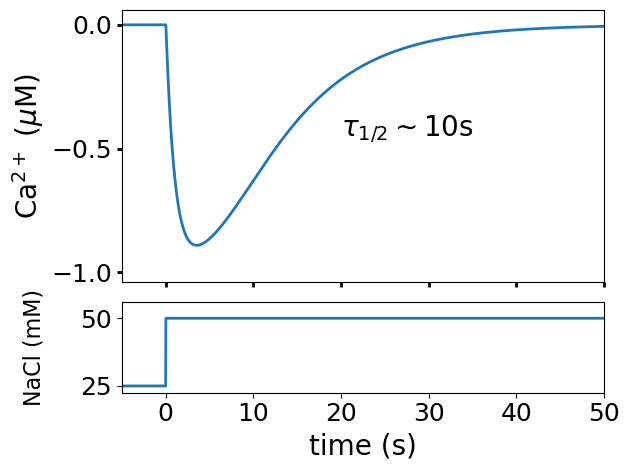

In [3]:
import matplotlib.pyplot as plt
plt.close('all')



f, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
f.figsize=(10,6)

ax1.plot(model_10.tvec, model_10.Ca,  lw=2, alpha=1)
ax1.set_ylim((-1.04,0.06))
#ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax1.yaxis.major.formatter._useMathText = True
#ax1.yaxis.get_offset_text().set_fontsize(14)

ax1.text(20, -0.45, r'$\tau_{\mathrm{1/2}} \sim$10s', fontsize = 20)
ax1.set_ylabel(r"$\mathrm{Ca}^{2+}$ ($\mu$M)", fontsize=20) 
ax1.set_yticks([-1.0,-0.5,0.0], minor=False)

ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(width=2)

ax2.plot(model_10.tvec, model_10.concentracion,   lw=2)

ax2.set_ylim((22.5,56))
ax2.set_ylabel("NaCl (mM)", fontsize=16) 

plt.xlim((-5,50))
f.subplots_adjust(hspace=0.1)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.xlabel("time (s)", fontsize=20)
f.align_ylabels((ax1, ax2))
f.tight_layout()
#plt.savefig("upstep_Ca.pdf")
plt.show()

In [4]:
model_10 = OFF(breed=1)

model_10.run(step1=50, step2=25)

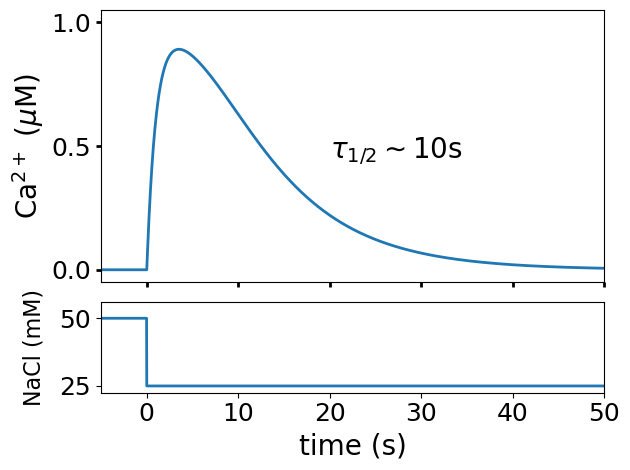

In [5]:
import matplotlib.pyplot as plt
plt.close('all')



f, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
f.figsize=(10,6)

ax1.plot(model_10.tvec, model_10.Ca,  lw=2, alpha=1)
#ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax1.yaxis.major.formatter._useMathText = True
#ax1.yaxis.get_offset_text().set_fontsize(14)

ax1.text(20, 0.45, r'$\tau_{\mathrm{1/2}} \sim$10s', fontsize = 20)
ax1.set_ylabel(r"$\mathrm{Ca}^{2+}$ ($\mu$M)", fontsize=20) 

ax1.set_yticks([0.0,0.50,1.0], minor=False)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(width=2)

ax2.plot(model_10.tvec, model_10.concentracion,   lw=2)

ax2.set_ylim((22.5,56))
ax2.set_ylabel("NaCl (mM)", fontsize=16) 

plt.xlim((-5,50))
f.subplots_adjust(hspace=0.1)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.xlabel("time (s)", fontsize=20)
f.align_ylabels((ax1, ax2))
f.tight_layout()
#plt.savefig("downstep_Ca.pdf")
plt.show()

In [6]:
model_10 = OFF(preexposure=30000.0)

model_10.run(step1=25, step2=50)

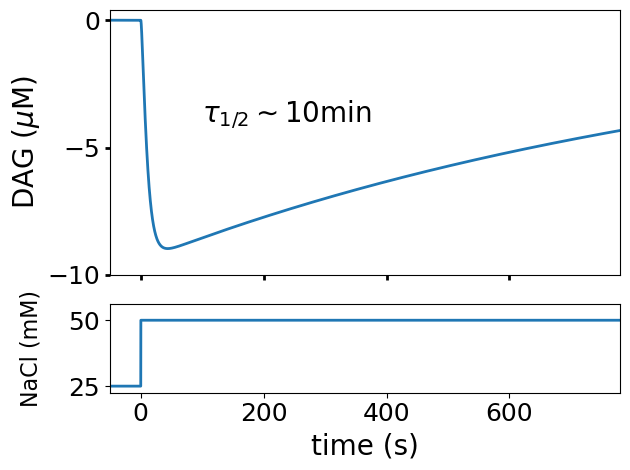

In [7]:
plt.close('all')

f, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
f.figsize=(10,6)

ax1.plot(model_10.tvec, model_10.DAG,  lw=2, alpha=1)
ax1.set_ylim((-10, 0.4))

ax1.text(100.5, -4.0, r'$\tau_{\mathrm{1/2}} \sim$10min', fontsize = 20)
ax1.set_ylabel(r"DAG ($\mu$M)", fontsize=20) 
ax1.set_yticks([-10.0,-5.0,0.0], minor=False)

ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(width=2)

ax2.plot(model_10.tvec, model_10.concentracion,   lw=2)

ax2.set_ylim((22.5,56))
ax2.set_ylabel("NaCl (mM)", fontsize=16) 

plt.xlim((-50,780))

f.subplots_adjust(hspace=0.1)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.xlabel("time (s)", fontsize=20)
f.align_ylabels((ax1, ax2))
f.tight_layout()

#plt.savefig("upstep_DAG.pdf")
plt.show()

In [8]:
model_10 = OFF(preexposure=30000.0)

model_10.run(step1=50, step2=25)

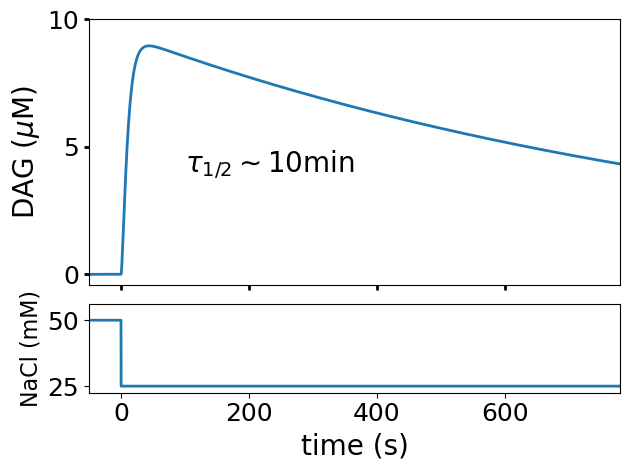

In [9]:
plt.close('all')


f, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
f.figsize=(10,6)

ax1.plot(model_10.tvec, model_10.DAG,  lw=2, alpha=1)
ax1.set_ylim((-0.4, 10))

ax1.text(100.5, 4.0, r'$\tau_{\mathrm{1/2}} \sim$10min', fontsize = 20)
ax1.set_ylabel(r"DAG ($\mu$M)", fontsize=20)
ax1.set_yticks([0.0, 5.0, 10.0], minor=False)

ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(width=2)

ax2.plot(model_10.tvec, model_10.concentracion,   lw=2)

ax2.set_ylim((22.5,56))
ax2.set_ylabel("NaCl (mM)", fontsize=16) 

plt.xlim((-50,780))

f.subplots_adjust(hspace=0.1)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.xlabel("time (s)", fontsize=20)
f.align_ylabels((ax1, ax2))
f.tight_layout()
#plt.savefig("downstep_DAG.pdf")
plt.show()

In [3]:
model_low = OFF(breed=0)
model_low.run(step1=1, step2=0)

model_high = OFF(breed=1)
model_high.run(step1=1, step2=0)

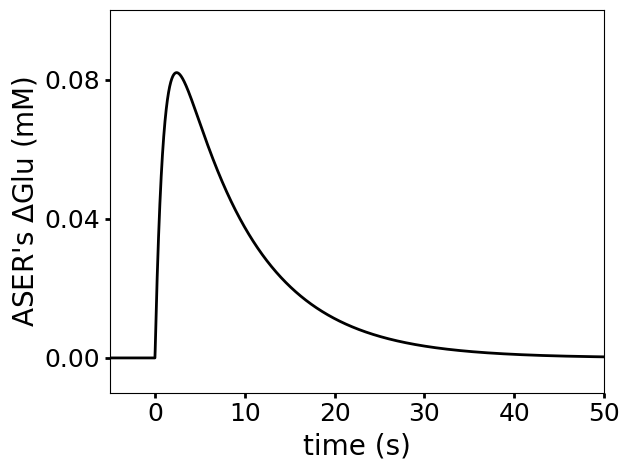

In [14]:
import matplotlib.pyplot as plt
plt.close('all')

# Three subplots sharing both x/y axes
f, (ax2) = plt.subplots( )


ax2.plot(model_low.tvec, model_low.Ca,  color='k', lw=2, alpha=1)
ax2.set_yticks([0.0,0.04,0.08], minor=False)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(width=2)
ax2.set_ylim((-0.01,0.1))
ax2.set_xlim((-5,50))
ax2.set_xlabel("time (s)", fontsize=20)
ax2.set_ylabel(r"ASER's $\Delta \mathrm{Glu}$ (mM)", fontsize=20)


ax2.tick_params(width=2)

plt.xlim((-5,50))

plt.xlabel("time (s)", fontsize=20)
plt.tight_layout()

#plt.savefig("pre_post_ASER.pdf",bbox_inches="tight")
plt.show()

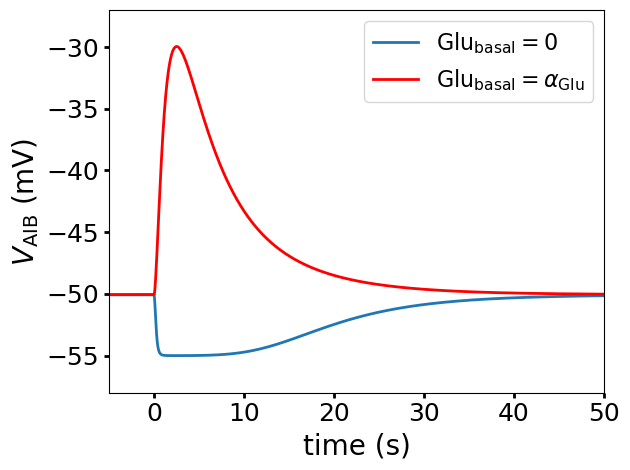

In [4]:
import matplotlib.pyplot as plt
plt.close('all')

# Three subplots sharing both x/y axes
f, (ax3) = plt.subplots( )


ax3.plot(model_low.tvec, model_low.V_post, label = r"$\mathrm{Glu_{basal}}=0$", lw=2)
ax3.plot(model_high.tvec, model_high.V_post, label = r"$\mathrm{Glu_{basal}}= \alpha_{\mathrm{Glu}}$", color="r", lw=2)

ax3.tick_params(axis='both', which='major', labelsize=18)
ax3.tick_params(axis='both', which='major', labelsize=18)
ax3.set_ylim((-58,-27))

ax3.tick_params(width=2)
ax3.legend( fontsize=16)


ax3.set_ylabel(r"$V_{\mathrm{AIB}}$ (mV)", fontsize=20)
plt.xlim((-5,50))

plt.xlabel("time (s)", fontsize=20)
plt.tight_layout()

plt.savefig("pre_post_AIB.pdf",bbox_inches="tight")
plt.show()